In [ ]:
import time

import jax
import jaxlie
import jax.numpy as jnp
import numpy as onp
import pyroki as pk
import viser
from matplotlib import pyplot as plt
from robot_descriptions.loaders.yourdfpy import load_robot_description
from viser.extras import ViserUrdf


In [16]:
# Visualization setup.
if 'server' not in globals() or server is None:
    server = viser.ViserServer()
else:
    server.scene.reset()
    server.gui.reset()

server.scene.add_grid("/ground", width=2, height=2)

urdf = load_robot_description("panda_description")
target_link_name = "panda_hand"
robot = pk.Robot.from_urdf(urdf)

# Setup robot constants and visualization.
PANDA_HOME = jnp.array([0, -jnp.pi/4, 0, -3*jnp.pi/4, 0, jnp.pi/2, jnp.pi/4, 0.])
robot_vis = ViserUrdf(server, urdf, root_node_name="/base")
initialization_vis = ViserUrdf(server, urdf, root_node_name="/base_init", mesh_color_override=[0.7, 0.7, 0.7, 0.1])
robot_vis.update_cfg(onp.asarray(PANDA_HOME))
initialization_vis.update_cfg(onp.asarray(PANDA_HOME))

# Viser GUI elements. 
with server.gui.add_folder("Optimization Controls"):
    gui_method = server.gui.add_dropdown(
        "Method", 
        options=["Newton", "Gradient Descent"], 
        initial_value="Newton"
    )
    gui_use_ls = server.gui.add_checkbox(
        "Use Parallel Line Search", 
        initial_value=True
    )
    gui_reset = server.gui.add_button("Reset to Home")

ik_target = server.scene.add_transform_controls(
    "/ik_target", scale=0.2, position=fk_ee.translation(), wxyz=fk_ee.rotation().wxyz
)
timing_handle = server.gui.add_number("Elapsed (ms)", 0.001, disabled=True)

# Pre-compute target link index and home FK.
target_link_index = robot.links.names.index(target_link_name)
fk_ee = jaxlie.SE3(robot.forward_kinematics(PANDA_HOME)[target_link_index])

# Pre-compute alphas for line search: log-spaced between 1e-5 and 1
ALPHAS = jnp.logspace(-6, 0, 30)

## Jax-based inverse kinematics (IK).

Here we implement IK using a couple different algorithms (gradient descent and Newton's method) using
PyRoki for differentiable FK, and Jax for automatic differentiation and optimization.

The problem we solve is formulated as:
$$ \min_{\bm{q} \in \mathbb{R}^n} \| \textrm{FK}(\bm{q}) \ominus \bm{T}_\textrm{target} \|^2 $$

where $\bm{q}$ are the joint angles, $\textrm{FK}(\bm{q}): \mathbb{R}^n \rightarrow SE(3)$ is the forward kinematics function returning
the end-effector pose, $\bm{T}_\textrm{target} \in SE(3)$ is the target end-effector pose, and $\ominus$ is the pose difference operator:
$$ \bm{T}_1 \ominus \bm{T}_2 = \begin{bmatrix} \textrm{log}(\bm{R}_2^T \bm{R}_1) \\ \bm{p}_1 - \bm{p}_2 \end{bmatrix} $$

where $\bm{T}_i = \begin{bmatrix} \bm{R}_i & \bm{p}_i \\ 0 & 1 \end{bmatrix} \in SE(3)$, $\bm{R}_i \in SO(3)$ is the rotation matrix, $\bm{p}_i \in \mathbb{R}^3$ is the position vector, and $\textrm{log}(\cdot)$ is the matrix logarithm mapping from $SO(3)$ to $\mathbb{R}^3$.

In [23]:

def loss(q: jnp.ndarray, ee_target: jaxlie.SE3, pos_weight: float = 10.0, rot_weight: float = 1.0) -> jnp.ndarray:
    """IK loss function using SE(3) manifold distance.
    
    Args:
        q: Joint configuration. Shape (num_dof,)
        ee_target: Target end-effector pose, jaxlie.SE3.
        pos_weight: Weight for position error.
        rot_weight: Weight for rotation error.
    """
    ee_tf = jaxlie.SE3(robot.forward_kinematics(q)[target_link_index])
    # Manifold distance (Log map)
    err = jaxlie.manifold.rminus(ee_target, ee_tf)
    pos_err = err[..., :3]
    rot_err = err[..., 3:]
    return pos_weight * jnp.sum(pos_err**2) + rot_weight * jnp.sum(rot_err**2)

@jax.jit
def compute_newton_direction(q: jnp.ndarray, ee_target: jaxlie.SE3) -> jnp.ndarray:
    """Computes the Newton step."""
    grad = jax.grad(loss)(q, ee_target)
    hess = jax.hessian(loss)(q, ee_target)
    
    # Add regularizatoin to Hessian for numerical stability
    hess = hess + jnp.abs(jnp.diag(jnp.diag(hess)* 1e-1 + 1e-6))
    
    return -jnp.linalg.solve(hess, grad)

@jax.jit
def compute_grad_direction(q: jnp.ndarray, ee_target: jaxlie.SE3) -> jnp.ndarray:
    """Computes the negative gradient direction for gradient descent."""
    grad = jax.grad(loss)(q, ee_target)
    return -grad 

@jax.jit
def parallel_line_search_step(
    q: jnp.ndarray, 
    direction: jnp.ndarray, 
    ee_target: jaxlie.SE3
) -> jnp.ndarray:
    """
    Evaluates q + alpha * direction for multiple alphas in parallel using vmap.

    Args:
        q: Current joint configuration. Shape (num_dof,)
        direction: Descent direction. Shape (num_dof,)
        ee_target: Target end-effector pose, jaxlie.SE3.
    """
    # 1. Create batch of candidates: (num_alphas, num_dof)
    candidates = q + ALPHAS[:, None] * direction

    print(candidates.shape, ee_target.translation().shape)
    
    # 2. Evaluate loss for all candidates at once
    # vmap over the first axis of candidates (0), keep ee_target fixed (None)
    losses = jax.vmap(loss, in_axes=(0, None))(candidates, ee_target)
    
    # 3. Pick the best one
    best_idx = jnp.argmin(losses)
    return candidates[best_idx]

Click [here](http://localhost:8080) to view the interactive demo in your browser (you must run the cell below for the solvers to run). 

You can change the target pose by dragging the transform widget in the 3D viewer. You can also change the IK algorithm and parameters in the sidebar.

In [24]:
# GUI callback flag for robot reset.
reset_signal = [False]

@gui_reset.on_click
def _(_):
    """GUI callback to signal reset."""
    reset_signal[0] = True

# --- Main Loop ---
q = PANDA_HOME.copy()

while True:
    # 1. Handle Reset Synchronously (Thread-safe)
    if reset_signal[0]:
        q = PANDA_HOME.copy()
        reset_signal[0] = False # Reset the flag
        
    start_time = time.time()
    # 2. Get Target
    ee_target = jaxlie.SE3(jnp.concatenate([ik_target.wxyz, ik_target.position]))
    
    # 3. Compute Direction
    if gui_method.value == "Newton":
        direction = compute_newton_direction(q, ee_target)
    else:
        direction = compute_grad_direction(q, ee_target)

    # 4. Apply Step
    if gui_use_ls.value:
        q = parallel_line_search_step(q, direction, ee_target)
    else:
        lr = 1.0 if gui_method.value == "Newton" else 1e-2
        q = q + lr * direction

    # Update timing handle.
    elapsed_time = time.time() - start_time
    timing_handle.value = 0.5 * timing_handle.value + 0.5 * (elapsed_time * 1000)

    # 5. Visualize
    robot_vis.update_cfg(onp.asarray(q))
    time.sleep(0.05)

(30, 8) (3,)


KeyboardInterrupt: 

### General comparison

We also provide a general comparison of the two algorithms implemented here (gradient descent and Newton's method) on a 7-DOF robot arm, from some random initial configurations and target poses.

We sample 50 initial configurations, and set their target poses as small deviations from the FK of those configurations. We then run both algorithms from the same initial configurations to reach the same target poses, and measure the number of iterations and time taken to converge to a solution within a certain tolerance.

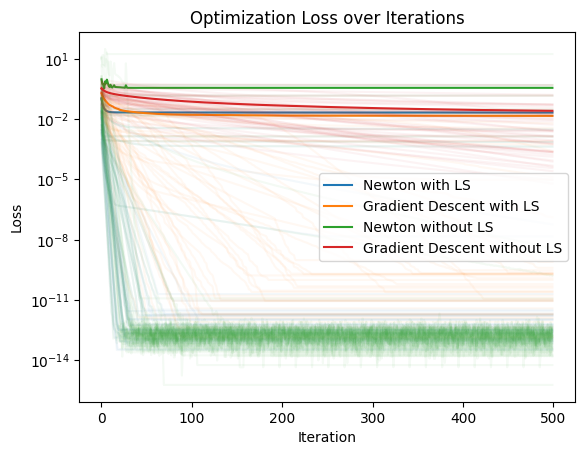

In [25]:
# Sample initial configurations
q_0 = jax.random.uniform(
    jax.random.PRNGKey(0), 
    shape=(50, robot.joints.num_actuated_joints), 
    minval=robot.joints.lower_limits, 
    maxval=robot.joints.upper_limits
)

# Set EE targets as small perturbations of random FKs. 
ee_targets = jaxlie.SE3(robot.forward_kinematics(q_0)[:, target_link_index]) @ jaxlie.SE3.exp(jax.random.normal(jax.random.PRNGKey(1), (50, 6)) * 1e-1)

# Setup line plot for visualization.
figure = plt.figure()
plt.title("Optimization Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")

num_iterations = 500

# Pre-vmap functions for speed.
newton_direction = jax.vmap(compute_newton_direction)
grad_direction = jax.vmap(compute_grad_direction)
parallel_line_search_step = jax.vmap(parallel_line_search_step)

# Run experiments - iterate over methods and line search usage.
for use_ls in [True, False]:
    for method in ["Newton", "Gradient Descent"]:
        losses = []
        q = q_0.copy() # Initialize current q
        
        for i in range(num_iterations):
            if method == "Newton":
                compute_direction = newton_direction
            else:
                compute_direction = grad_direction
            
            directions = compute_direction(q, ee_targets)
            
            if use_ls:
                # Parallel line search step
                q = parallel_line_search_step(q, directions, ee_targets)
            else:
                lr = 1.0 if method == "Newton" else 1e-2
                q = q + lr * directions
            
            current_losses = jax.vmap(loss)(q, ee_targets)
            losses.append(current_losses)
        
        # Post-process losses
        losses = onp.array(losses)  
        avg_loss = onp.mean(losses, axis=1)

        # Plot average and individual losses.
        avg_line = plt.plot(avg_loss, label=f"{method} {'with' if use_ls else 'without'} LS")
        for b in range(losses.shape[1]):
            plt.plot(losses[:, b], color=avg_line[0].get_color(), alpha=0.05)

plt.legend()
plt.show()

### Discussion

Above we see the "typical" tradeoff between Newton's method and gradient descent: Newton's method converges on average much more quickly, but it is less robust to initial condition (and has quite a few more outliers). Gradient descent is more robust, but takes many more iterations to converge. 

This intuition tends to hold in general for many optimization problems - if you have something "small" and "smooth," Newton can be dramatically better - but if you cannot provide a good guess, or have a large and complex problem, gradient descent may be more reliable.